In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.models import load_model

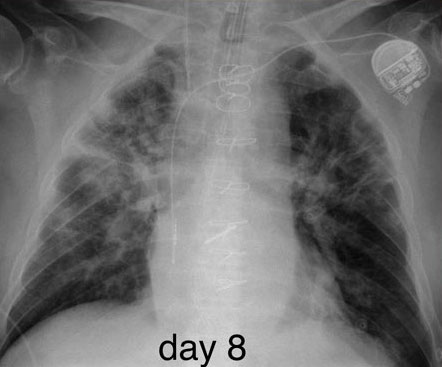

In [2]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = './dataset/covid/extubation-8.jpg'
display(Image(img_path))

In [14]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
#         print(last_conv_layer_output, last_conv_layer_output.shape )
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
#         print(class_channel)
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

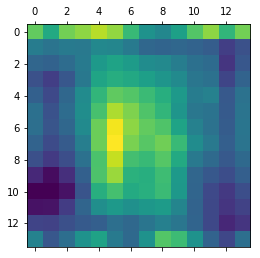

In [15]:
data = []
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
data.append(image)
data = np.array(data) / 255.0

# Make model
model = tf.keras.models.load_model('./vgg16_weight/covid_19_model.h5')
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(data, 1)
# print(preds)
pred_class = np.argmax(preds[0])    
# print(pred_class)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(data, model, last_conv_layer_name, pred_class)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

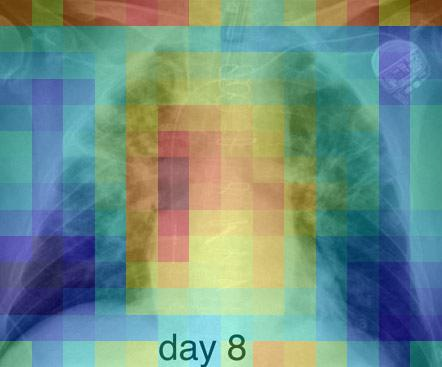

In [8]:
save_and_display_gradcam(img_path, heatmap)

In [12]:
def plot_heatmap(heatmap, img_path):
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(img_path)
    fig, ax = plt.subplots() 
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.savefig('1.png',bbox_inches="tight")
    

numpy.ndarray

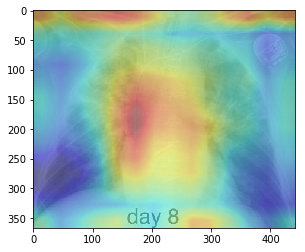

In [11]:
plot_heatmap(heatmap, img_path)
type(heatmap)